<a href="https://colab.research.google.com/github/AstridSerruto/Projects/blob/master/Other/Copy_of_A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A/B Testing
Mobile Puzzle Game 'Cookie Cats'

In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cookie_cats.csv to cookie_cats (2).csv


In [ ]:
# Dataset is now stored in a Pandas Dataframe
import io
ab_data = pd.read_csv(io.BytesIO(uploaded['cookie_cats.csv']))

In [ ]:
#Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

Explore the data

In [ ]:
#Data set information
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [ ]:
#Top 5 rows
ab_data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
#Number of rows in the data set
ab_data.shape

(90189, 5)

How is this data performing

In [ ]:
# How large is each group?
print('test sample size:', len(ab_data[ab_data.sum_gamerounds == 1]))
print('control sample size:', len(ab_data[ab_data.sum_gamerounds == 0]))
print('test proportion:', ab_data.sum_gamerounds.mean())
print()

# What is the signup rate of test and control?
print('test signup rate:', ab_data[ab_data.sum_gamerounds == 1].retention_7.mean())
print('control signup rate:', ab_data[ab_data.sum_gamerounds == 0].retention_1.mean())

# Are the test and control groups significantly different?
stats.ttest_ind(ab_data[ab_data.sum_gamerounds == 1].retention_7,
                ab_data[ab_data.sum_gamerounds == 0].retention_1)

test sample size: 5538
control sample size: 3994
test proportion: 51.8724567297564

test signup rate: 0.007403394727338389
control signup rate: 0.021782674011016526


Ttest_indResult(statistic=-6.028779169316372, pvalue=1.7133537644430434e-09)

A/B Testing


The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

userid - a unique number that identifies each player.
version - whether the player was put in the 

control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).

sum_gamerounds - the number of game rounds played by the player during the first 14 days after install.

retention_1 - did the player come back and play 1 day after installing?

retention_7 - did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. 


In [ ]:
#Number of players in gate_30 and gate_40
ab_data.groupby('version')['version'].count()

version
gate_30    44700
gate_40    45489
Name: version, dtype: int64

There roughly the same number of players in each group.


<Figure size 792x360 with 0 Axes>

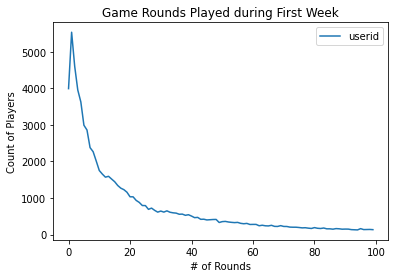

In [ ]:
#Distribution of the number of game rounds players played during the first week playing the game..
%matplotlib inline

#Number of players for each number of gamerounds
plt_ab_data = ab_data.groupby('sum_gamerounds').count().reset_index()

#Distribution of players that played 0 to 100 game rounds
plt.figure(figsize = (11, 5))
ax = plt_ab_data.head(n=100).plot('sum_gamerounds', 'userid')
ax.set_xlabel("# of Rounds")
ax.set_ylabel("Count of Players")
ax.set_title("Game Rounds Played during First Week");
plt.show()


In the plot above we can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked!

What we want is for players to like the game and to get hooked. A common metric in the video gaming industry for how fun and engaging a game is 1-day retention: The percentage of players that comes back and plays the game one day after they have installed it. The higher 1-day retention is, the easier it is to retain players and build a large player base.




In [ ]:
#1-day retention overall
ab_data['retention_1'].mean()

0.4452095044850259

A little less than half of the players come back one day after installing the game. With this benchmark, let's look at how 1-day retention differs between the two AB-groups.

In [ ]:
#1-day retention for each AB_group
ab_data.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%).Small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?

To get to the certanty of the retention numbers we will use bootstrapping. The dataset will be repeatedly re-sampled with replacements and we will calculate 1-day retention for those samples. Variation in 1-day retention will give us and indication of how uncertain retention numbers are. We will be using 10000 replacemnts.

Text(0.5, 0, '1-Day Retention Mean')

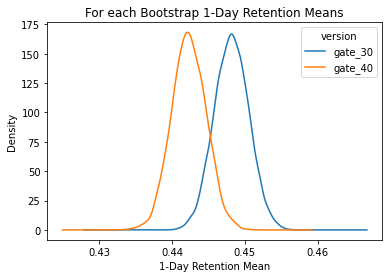

In [ ]:
#List with bootstrapped means for each AB-group
boot_1d = []
iterations=10000
for i in range(iterations):
  boot_mean = ab_data.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
  boot_1d.append(boot_mean)

#Change list to a dataframe
boot_1d = pd.DataFrame(boot_1d)

#Estimate plot of bootstrap distributions
ax = boot_1d.plot.kde()
ax.set_title('For each Bootstrap 1-Day Retention Means')
ax.set_xlabel('1-Day Retention Mean')


The two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. We can see that there seems to be some evidence of a difference, albeit small. We will review the difference.
 

Text(0.5, 1.0, 'Bootstrap % Defference in 1-Day Retention Means')

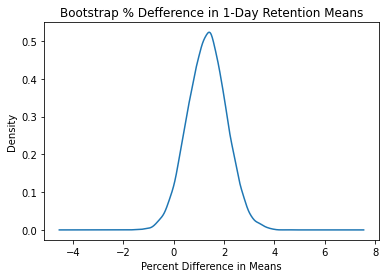

In [ ]:
#Adding a column for the % difference.
boot_1d['diff'] = ((boot_1d.gate_30 - boot_1d.gate_40)/ boot_1d.gate_40 * 100)

#Visualize the boostrap % difference
ax = boot_1d['diff'].plot.kde()
ax.set_xlabel('Percent Difference in Means')
ax.set_title('Bootstrap % Defference in 1-Day Retention Means')

From this chart, we can see that the most likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. But what is the probability that the difference is above 0%? 

In [ ]:
# Probability that 1-day retention is greater when gate is at level 30.
boot_1d_prob = (boot_1d['diff'] > 0).mean()
'{0:.1%}'.format(boot_1d_prob)

'95.9%'

The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. But many players playing the game on the first day will not reach level 30, since players have only been playing the game for one day. 

But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.

In [ ]:
# 7-day retention for both AB-groups
ab_data.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

As with 1-day retention, we see that 7-day retention is lower when the gate is at level 40. The difference is also larger for 1-day retention, presumably more players gave had time to hit the first gate after 7 days. We also see that the overall 7-day retention is lower than the 1-day retention, as fewer people continue to play a game after installing it.
At 7-day retention, how certain is the difference between AB-groups?

'99.9%'

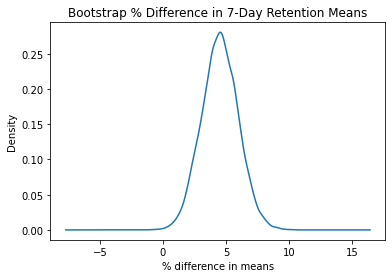

In [ ]:
#List with bootstrapped means for each AB-group
boot_7d =[]
for i in range(10000):
  boot_mean = ab_data.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
  boot_7d.append(boot_mean)

#Change the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

#Adding column with % difference between AB-groups
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

#Ploting the % difference
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel("% difference in means")
ax.set_title('Bootstrap % Difference in 7-Day Retention Means');

# Calculating the probability that 7-day retention is greater when the gate is at level 30
day7_prob = (boot_7d['diff'] > 0).mean()

# Printing the probability
'{0:.1%}'.format(day7_prob)

The result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30. 